In [1]:
import torch
import pandas as pd
import os
import numpy as np
import COSMO_TL as ctl
from dask.distributed import Client, LocalCluster, progress
import dask
from scipy.interpolate import RegularGridInterpolator
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interpn
from scipy.interpolate import LinearNDInterpolator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy.optimize import curve_fit, minimize, differential_evolution
# get particle swarm optimizer
from pyswarm import pso
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pandas as pd

In [5]:
def get_X_solute(df):
    X = df[['volume_solute', 'area_solute', 'NC_K', 'SIGMA_K','TAU', 'default_error']]
    sig_cols = [col for col in df.columns if 'sigma_solute' in col]
    sigs = df[sig_cols].to_numpy()
    X = X.to_numpy().reshape(len(df), -1)
    X = np.column_stack((X, sigs))
    return X

def get_X_solvent(df):
    X = df[['volume_solvent', 'area_solvent','NC_K','SIGMA_K','TAU', 'default_error']]
    sig_cols = [col for col in df.columns if 'sigma_solvent' in col]
    sigs = df[sig_cols].to_numpy()
    X = X.to_numpy().reshape(len(df), -1)
    X = np.column_stack((X, sigs))
    return X

def get_X(df):
    X_solute = get_X_solute(df)
    X_solvent = get_X_solvent(df)
    # solvent prop cols = eps,n,alpha,beta,gamma,phi**2,psi**2,beta**2
    solvent_props_names = ['eps', 'n', 'alpha', 'beta', 'gamma', 'phi**2', 'psi**2', 'beta**2']
    solvent_props = df[solvent_props_names].to_numpy()
    X = np.column_stack((X_solute, X_solvent, solvent_props))
    return X
# given a dataframe return a dataframe with the mean value for all columns with error in the name
# grouped by SoluteName
def get_mean_df(df):
    df2 = df.copy()
    original_columns = list(df2.columns)
    print(original_columns)
    cols = [col for col in df2.columns if 'error' in col]
    original_columns = [col for col in original_columns if col not in cols]
    df3 = df2.groupby(['SoluteName', 'NC_K','SIGMA_K','TAU'])[cols].mean()
    df3 = df3.reset_index()
    # return a dataframe with the unique values in SoluteName and the mean values for all columns with error in the name
    # get all the other colums  from the original dataframe
    df4 = df2[original_columns]
    df4 = df4.reset_index(drop=True)
    df5 = pd.merge(df4, df3, on=['SoluteName', 'NC_K','SIGMA_K','TAU'])
    df5 = df5.drop_duplicates()
    return df5

In [6]:
df = pd.read_csv('../data/vaspsol_data_03_19_2023.csv')
print(len(df))
df['error'] = df['error'].abs()
df = df[df['error'] < 10]
df = df[df['Solvent'] == 'water']
df = df[df['Charge'] == 0]
NC_K_default = 0.0025
SIGMA_K_default = 0.6
TAU_default = 0.000525
default_df = df[(df['NC_K'] == NC_K_default) & (df['SIGMA_K'] == SIGMA_K_default) & (df['TAU'] == TAU_default)]
default_df

7911


,Unnamed: 0,Solvent,FileHandle,directory,NC_K,SIGMA_K,TAU,Solvation_Energy,Total_Energy,No.,...,sigma_solvent_41,sigma_solvent_42,sigma_solvent_43,sigma_solvent_44,sigma_solvent_45,sigma_solvent_46,sigma_solvent_47,sigma_solvent_48,sigma_solvent_49,sigma_solvent_50
54,54,water,0157flu,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.0025,0.6,0.000525,-0.076483,-76.381271,2240,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55,55,water,0157flu,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.0025,0.6,0.000525,-0.063630,-76.330931,2240,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56,56,water,0157flu,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.0025,0.6,0.000525,-0.063649,-76.330950,2240,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57,57,water,0157flu,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.0025,0.6,0.000525,-0.063630,-76.330931,2240,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,60,water,0157flu,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.0025,0.6,0.000525,-0.063630,-76.330931,2240,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7019,7019,water,n016,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.0025,0.6,0.000525,-0.274200,-64.314735,2363,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7020,7020,water,n016,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.0025,0.6,0.000525,-0.274198,-64.314733,2363,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7021,7021,water,0100met,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.0025,0.6,0.000525,-0.138310,-129.040780,2187,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7022,7022,water,0100met,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.0025,0.6,0.000525,-0.138300,-129.040770,2187,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_to_append = default_df[['SoluteName','error']]
# rename error to default_error
df_to_append = df_to_append.rename(columns={'error': 'default_error'})
df_to_append

,SoluteName,default_error
54,fluorobenzene,0.983698
55,fluorobenzene,0.687308
56,fluorobenzene,0.687746
57,fluorobenzene,0.687308
60,fluorobenzene,0.687308
...,...,...
7019,"1,2-ethanediamine",3.396948
7020,"1,2-ethanediamine",3.396994
7021,methylhexanoate,0.699429
7022,methylhexanoate,0.699198


In [8]:
# match up the default error back to the original dataframe
df = pd.merge(df, df_to_append, on=['SoluteName'])
# this expanded the number of rows in the dataframe. This is not what we want
df = df.drop_duplicates('Unnamed: 0')
df

,Unnamed: 0,Solvent,FileHandle,directory,NC_K,SIGMA_K,TAU,Solvation_Energy,Total_Energy,No.,...,sigma_solvent_42,sigma_solvent_43,sigma_solvent_44,sigma_solvent_45,sigma_solvent_46,sigma_solvent_47,sigma_solvent_48,sigma_solvent_49,sigma_solvent_50,default_error
0,0,water,0157flu,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.001000,0.200000,0.000670,0.073867,-76.193434,2240,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.983698
5,1,water,0157flu,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.002000,0.866667,0.000010,-0.200151,-76.467452,2240,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.983698
10,2,water,0157flu,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.001000,1.200000,0.001000,-0.042744,-76.310045,2240,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.983698
15,3,water,0157flu,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.001000,0.200000,0.001000,0.152467,-76.114834,2240,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.983698
20,4,water,0157flu,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.003000,0.533333,0.000340,-0.097007,-76.364308,2240,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.983698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36539,7021,water,0100met,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.002500,0.600000,0.000525,-0.138310,-129.040780,2187,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.699429
36542,7022,water,0100met,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.002500,0.600000,0.000525,-0.138300,-129.040770,2187,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.699429
36545,7023,water,0100met,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.003660,0.581300,0.000936,-0.125560,-129.028030,2187,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.699429
36548,7024,water,0100met,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.002500,0.600000,0.000525,-0.138300,-129.040770,2187,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.699429


In [9]:
# how many unique values of NC_K, SIGMA_K, TAU are there?
df[['NC_K', 'SIGMA_K', 'TAU']].drop_duplicates()
print(len(df['NC_K'].unique())), print(len(df['SIGMA_K'].unique())), print(len(df['TAU'].unique()))


454
433
443


(None, None, None)

In [10]:
NC_K_opt = 0.003
SIGMA_K_opt = 0.64203644
TAU_opt = 0.0007722
df_opt = df[(df['NC_K'] == NC_K_opt) & (df['SIGMA_K'] == SIGMA_K_opt) & (df['TAU'] == TAU_opt)]
df_opt

,Unnamed: 0,Solvent,FileHandle,directory,NC_K,SIGMA_K,TAU,Solvation_Energy,Total_Energy,No.,...,sigma_solvent_42,sigma_solvent_43,sigma_solvent_44,sigma_solvent_45,sigma_solvent_46,sigma_solvent_47,sigma_solvent_48,sigma_solvent_49,sigma_solvent_50,default_error
290,58,water,0157flu,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.003,0.642036,0.000772,-0.061213,-76.328514,2240,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.983698
615,123,water,0169chl,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.003,0.642036,0.000772,-0.047073,-30.669899,2249,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.550778
1151,243,water,0151phy,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.003,0.642036,0.000772,-0.457332,-98.549717,2237,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.346444
1416,308,water,0198chl,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.003,0.642036,0.000772,-0.115313,-22.649219,2268,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.751819
1672,372,water,0163chl,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.003,0.642036,0.000772,-0.059260,-39.105335,2244,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.790288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36315,6941,water,0051cyc,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.003,0.642036,0.000772,-0.164702,-88.967645,2140,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.088996
36336,6948,water,0147met,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.003,0.642036,0.000772,-0.218326,-74.987222,2233,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.061878
36358,6956,water,0409clb,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.003,0.642036,0.000772,-0.038648,-72.192003,2317,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.103664
36387,6967,water,0408hex,/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_...,0.003,0.642036,0.000772,0.006496,-30.425965,2316,...,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.263047


In [12]:
n = 20
# get the lowest error for each solute, NC_K, SIGMA_K, TAU. this is will df2
df2 = df.groupby(['SoluteName', 'NC_K', 'SIGMA_K', 'TAU'])['error'].min().reset_index()[['SoluteName', 'NC_K', 'SIGMA_K', 'TAU', 'error']]
# make sure each group has the same unique FileHandle. Use df2 to construct which FileHandles to include
df_grouped = df2.groupby(['NC_K', 'SIGMA_K', 'TAU'])
# get groups with at least 5 members
df_filtered = df_grouped.filter(lambda x: len(x) >= n)
df_filtered = df_filtered.reset_index(drop=True)
# # create a dataframe with the mean values for all the columns grouping by NC_K, SIGMA_K, TAU. Remove the SoluteName column. use get_level_values to get the unique values of NC_K, SIGMA_K, TAU
df_temp = df_filtered.groupby(['NC_K', 'SIGMA_K', 'TAU']).mean().reset_index()[['NC_K', 'SIGMA_K', 'TAU','error']].drop_duplicates()
# print the number of observations of each group
counts = df_filtered.groupby(['NC_K', 'SIGMA_K', 'TAU']).count()['error']
# lets reset the df_temp dataframe to have a normal index and make the current indicies into columns
df_temp = df_temp.reset_index(drop=True)
# add the counts column to the dataframe
df_temp['counts'] = counts.values
# get the params of the minimum error
df_temp = df_temp.sort_values(by=['error'])
params_min = df_temp.iloc[0][['NC_K', 'SIGMA_K', 'TAU']].to_numpy()
solutes_min = df[(df['NC_K'] == params_min[0]) & (df['SIGMA_K'] == params_min[1]) & (df['TAU'] == params_min[2])]['SoluteName'].unique()
# get the unique solutes in params_min and the info of params min
# first pretty print a table of params min 
print('NC_K: ', params_min[0], 'SIGMA_K: ', params_min[1], 'TAU: ', params_min[2])
print('error: ', df_temp.iloc[0]['error'], 'counts: ', df_temp.iloc[0]['counts'])
print('solutes: ', len(solutes_min))
# pretty print the number of solutes in solutes_min
params = df_temp[['NC_K', 'SIGMA_K', 'TAU']].to_numpy()
# create a df containing the NC_K, SIGMA_K, TAU, and error for the minimum error. again filter to keep the minimum error for each group
dfs_temp = pd.concat([df[(df['NC_K'] == params[i][0]) & (df['SIGMA_K'] == params[i][1]) & (df['TAU'] == params[i][2])] for i in range(len(params))])
# keep only the solutes_min in dfs_temp
#dfs_temp = dfs_temp[dfs_temp['SoluteName'].isin(solutes_min)]
# get the minimum error for each group of NC_K, SIGMA_K, TAU, and SoluteName
dfs_temp = dfs_temp.groupby(['SoluteName', 'NC_K', 'SIGMA_K', 'TAU'])['error'].min().reset_index()[['SoluteName', 'NC_K', 'SIGMA_K', 'TAU', 'error']]
# group by NC_K, SIGMA_K, TAU to get the mean error for each group and add the counts column
# dfs_temp = dfs_temp.groupby(['NC_K', 'SIGMA_K', 'TAU']).mean().reset_index()[['NC_K', 'SIGMA_K', 'TAU','error']]
# dfs_temp['counts'] = counts.values
dfs_temp = dfs_temp.sort_values(by=['error'])
stats_df = pd.DataFrame()
dfs_temp_grouped = dfs_temp.groupby(['NC_K', 'SIGMA_K', 'TAU'])
# get all the params in the groups
stats_df['NC_K'] = dfs_temp_grouped['NC_K'].unique().apply(lambda x: x[0]).values
stats_df['SIGMA_K'] = dfs_temp_grouped['SIGMA_K'].unique().apply(lambda x: x[0]).values
stats_df['TAU'] = dfs_temp_grouped['TAU'].unique().apply(lambda x: x[0]).values
stats_df['mean_error'] = dfs_temp_grouped['error'].mean().values
stats_df['counts'] = dfs_temp_grouped['error'].count().values
stats_df

NC_K:  0.002997 SIGMA_K:  0.6482 TAU:  0.0008541
error:  1.091243323358137 counts:  215.0
solutes:  215


/tmp/ipykernel_1423/3430786993.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_temp = df_filtered.groupby(['NC_K', 'SIGMA_K', 'TAU']).mean().reset_index()[['NC_K', 'SIGMA_K', 'TAU','error']].drop_duplicates()


,NC_K,SIGMA_K,TAU,mean_error,counts
0,0.002187,0.969400,0.000374,4.836726,49
1,0.002500,0.600000,0.000525,1.152820,289
2,0.002750,0.660000,0.000472,1.481514,201
3,0.002997,0.648200,0.000854,1.091243,215
4,0.003000,0.642036,0.000772,1.118572,169
5,0.003660,0.581300,0.000936,1.101977,217


(-0.1, 5.0)

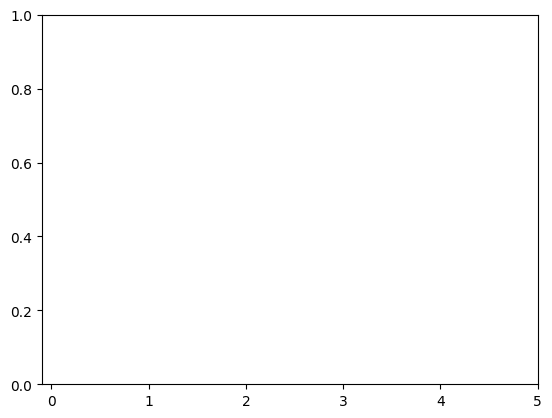

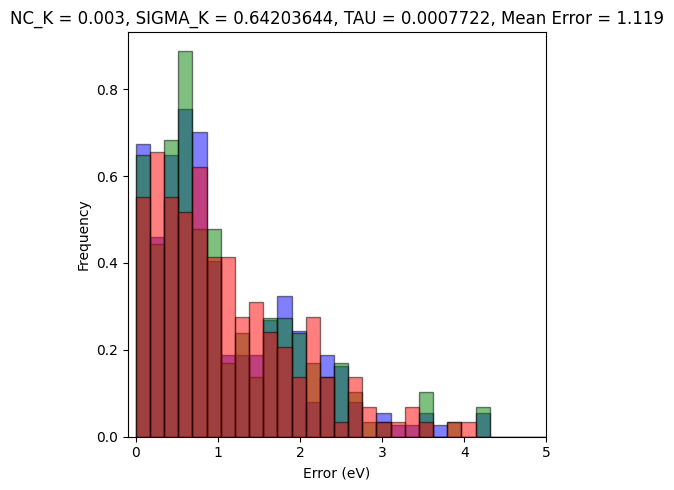

In [13]:

#make a histogram of the parameters in df_temp 
# colors = red green blue
colors = ['b','g','r']
# i = 0
# for n, s, t in zip(df_temp['NC_K'], df_temp['SIGMA_K'], df_temp['TAU']):
#     temp = df[(df['NC_K'] == n) & (df['SIGMA_K'] == s) & (df['TAU'] == t)]
#     # plot a normalized histogram of the error
#     temp['error'].hist(bins=30, density=True, alpha=0.5, label='NC_K = {}, SIGMA_K = {}, TAU = {}'.format(n, s, t), edgecolor='black', color=colors[i])
#     i += 1
# plt.legend()

# # make a similar plot but with KDEs
# for n, s, t in zip(df_temp['NC_K'], df_temp['SIGMA_K'], df_temp['TAU']):
#     temp = df[(df['NC_K'] == n) & (df['SIGMA_K'] == s) & (df['TAU'] == t)]
#     # plot a normalized histogram of the error
#     temp['error'].plot.kde(label='NC_K = {}, SIGMA_K = {}, TAU = {}'.format(n, s, t))
# # put the legend outside the plot


# remake this plot but with 3 panes for each combo

# fig, axs = plt.subplots(3, 1, figsize=(5, 5))
# bins = np.linspace(0, 5, 30)
# # have all the plots share the same x axis
# for i, (n, s, t) in enumerate(zip(df_temp['NC_K'], df_temp['SIGMA_K'], df_temp['TAU'])):
#     temp = df[(df['NC_K'] == n) & (df['SIGMA_K'] == s) & (df['TAU'] == t)]
#     # plot a normalized histogram of the error
#     axs[i].hist(temp['error'], bins=bins, density=True, alpha=0.5, label='NC_K = {}, SIGMA_K = {}, TAU = {}'.format(n, s, t), edgecolor='black', color=colors[i])
#     #axs[i].legend()
#     axs[i].set_xlabel('Error (eV)')
#     axs[i].set_ylabel('Frequency') 
#     # put the mean error in the title
#     axs[i].set_title('NC_K = {}, SIGMA_K = {}, TAU = {}, Mean Error = {}'.format(n, s, t, round(temp['error'].mean(), 3)))
    
    
plt.tight_layout()
plt.xlim(-0.1, 5)
# replot the historgrams but only for the top two params
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
bins = np.linspace(0, 5, 30)
# have all the plots share the same x axis
for i, (n, s, t) in enumerate(zip(df_temp['NC_K'], df_temp['SIGMA_K'], df_temp['TAU'])):
    temp = df[(df['NC_K'] == n) & (df['SIGMA_K'] == s) & (df['TAU'] == t)]
    # plot a normalized histogram of the error
    axs.hist(temp['error'], bins=bins, density=True, alpha=0.5, label='NC_K = {}, SIGMA_K = {}, TAU = {}'.format(n, s, t), edgecolor='black', color=colors[i])
    #axs[i].legend()
    axs.set_xlabel('Error (eV)')
    axs.set_ylabel('Frequency') 
    # put the mean error in the title
    axs.set_title('NC_K = {}, SIGMA_K = {}, TAU = {}, Mean Error = {}'.format(n, s, t, round(temp['error'].mean(), 3)))
    if i == 2:
        break

plt.tight_layout()
plt.xlim(-0.1, 5)


[4.50509704 1.11603523 1.47371547 1.12311076 1.11976868 1.10197655]
[0.1  0.74 0.26 0.42 0.58 0.9 ]


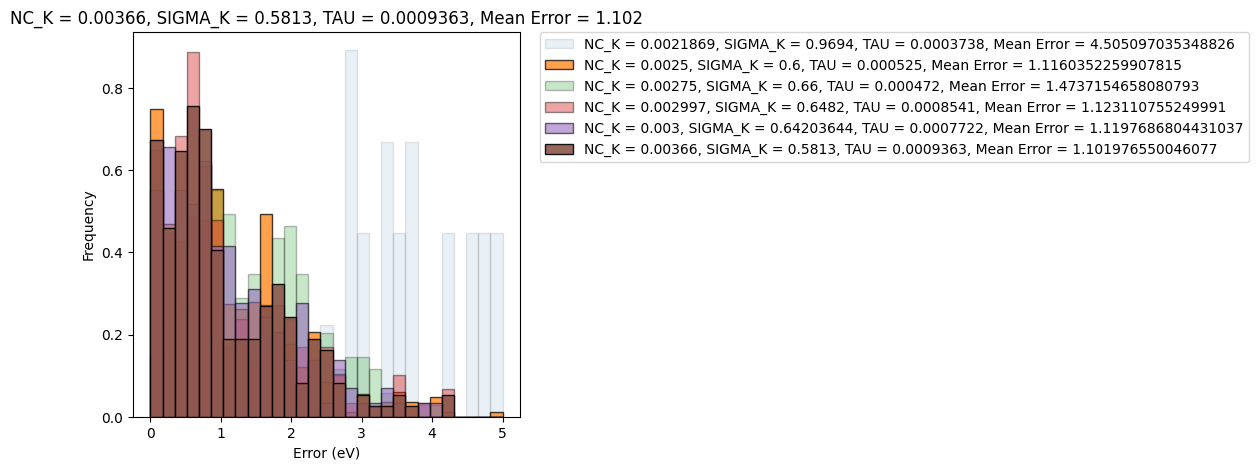

In [46]:
# for every combo of NC_K, SIGMA_K, TAU, in stats df plot the error hist of the data in df_temp. put them all on the same plot
# make the lowest error the most opaque
# make the highest error the least opaque
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
bins = np.linspace(0, 5, 30)
mean_errors = stats_df['mean_error'].values
# define alpha based on the error scale it linearly between 0 and 1
alphas = np.linspace(0.1, 0.9, len(mean_errors))
alphas = 1-alphas
print(mean_errors)
# reorganize the alphas so that the lowest error is the most opaque
alphas = alphas[np.argsort(mean_errors)]
print(alphas)
# have all the plots share the same x axis
for i, (n, s, t) in enumerate(zip(stats_df['NC_K'], stats_df['SIGMA_K'], stats_df['TAU'])):
    temp = df[(df['NC_K'] == n) & (df['SIGMA_K'] == s) & (df['TAU'] == t)]
    # plot a normalized histogram of the error. Add the mean error to label
    axs.hist(temp['error'], bins=bins, density=True, alpha=alphas[i], label='NC_K = {}, SIGMA_K = {}, TAU = {}, Mean Error = {}'.format(n, s, t, mean_errors[i]), edgecolor='black')
    #axs[i].legend()
    axs.set_xlabel('Error (eV)')
    axs.set_ylabel('Frequency') 
    # put the mean error in the title
    axs.set_title('NC_K = {}, SIGMA_K = {}, TAU = {}, Mean Error = {}'.format(n, s, t, round(temp['error'].mean(), 3)))
# put the legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

[[0.000875   0.00090657 0.00093813 ... 0.00393687 0.00396843 0.004     ]
 [0.000875   0.00090657 0.00093813 ... 0.00393687 0.00396843 0.004     ]
 [0.000875   0.00090657 0.00093813 ... 0.00393687 0.00396843 0.004     ]
 ...
 [0.000875   0.00090657 0.00093813 ... 0.00393687 0.00396843 0.004     ]
 [0.000875   0.00090657 0.00093813 ... 0.00393687 0.00396843 0.004     ]
 [0.000875   0.00090657 0.00093813 ... 0.00393687 0.00396843 0.004     ]] [[0.2        0.2        0.2        ... 0.2        0.2        0.2       ]
 [0.20808081 0.20808081 0.20808081 ... 0.20808081 0.20808081 0.20808081]
 [0.21616162 0.21616162 0.21616162 ... 0.21616162 0.21616162 0.21616162]
 ...
 [0.98383838 0.98383838 0.98383838 ... 0.98383838 0.98383838 0.98383838]
 [0.99191919 0.99191919 0.99191919 ... 0.99191919 0.99191919 0.99191919]
 [1.         1.         1.         ... 1.         1.         1.        ]] [[0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 ...
 [0.1 0.1 0.1 

c:\users\efons\anaconda3\envs\venv\lib\site-packages\matplotlib-3.6.2-py3.10-win-amd64.egg\matplotlib\contour.py:1479: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
c:\users\efons\anaconda3\envs\venv\lib\site-packages\matplotlib-3.6.2-py3.10-win-amd64.egg\matplotlib\contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
C:\Users\efons\AppData\Local\Temp\ipykernel_16100\2516684545.py:23: UserWarning: No contour levels were found within the data range.
  surf = ax.contour(NC_K_vals, SIGMA_K_vals, interp_vals)


IndexError: index 1 is out of bounds for axis 0 with size 1

c:\users\efons\anaconda3\envs\venv\lib\site-packages\matplotlib-3.6.2-py3.10-win-amd64.egg\matplotlib\transforms.py:2663: RuntimeWarning: divide by zero encountered in double_scalars
  y_scale = 1.0 / inh
c:\users\efons\anaconda3\envs\venv\lib\site-packages\matplotlib-3.6.2-py3.10-win-amd64.egg\matplotlib\transforms.py:2665: RuntimeWarning: invalid value encountered in double_scalars
  [0.0    , y_scale, (-inb*y_scale)],
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx 

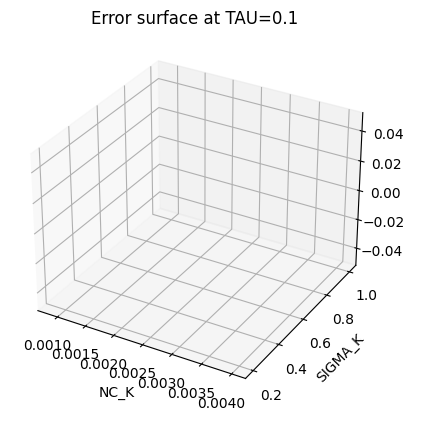

In [20]:

def plot_error_surface(df, tau_fixed):
    NC_K = df['NC_K'].values
    SIGMA_K = df['SIGMA_K'].values
    TAU = df['TAU'].values
    error = df['error'].values
    
    # Create a meshgrid of NC_K and SIGMA_K values
    nc_k_min, nc_k_max = np.min(NC_K), np.max(NC_K)
    sigma_k_min, sigma_k_max = np.min(SIGMA_K), np.max(SIGMA_K)
    nc_k_vals = np.linspace(nc_k_min, nc_k_max, 100)
    sigma_k_vals = np.linspace(sigma_k_min, sigma_k_max, 100)
    NC_K_vals, SIGMA_K_vals = np.meshgrid(nc_k_vals, sigma_k_vals)
    
    # Create a meshgrid of fixed TAU values
    tau_vals = np.ones_like(NC_K_vals) * tau_fixed
    
    # Interpolate the error surface using griddata
    pts = np.vstack((NC_K, SIGMA_K, TAU, error)).T
    interp_vals = griddata(pts[:, :3], pts[:, 3], (NC_K_vals, SIGMA_K_vals, tau_vals), method='linear')
    
    # Plot the error surface
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
    surf = ax.contour(NC_K_vals, SIGMA_K_vals, interp_vals)
    print(NC_K_vals, SIGMA_K_vals, tau_vals, interp_vals)
    # Add labels and titles
    ax.set_xlabel('NC_K')
    ax.set_ylabel('SIGMA_K')
    ax.set_zlabel('error')
    ax.set_title('Error surface at TAU={}'.format(tau_fixed))
    
    # Add a color bar
    fig.colorbar(surf)
    
    # Show the plot
    plt.show()

plot_error_surface(df2, 0.1)

(5656,) (5656,) (5656,) (5656, 1)
[[3.24246284 3.24246284 3.24246284 ...        nan        nan        nan]
 [3.24246284 3.24246284 3.24246284 ...        nan        nan        nan]
 [3.24246284 3.24246284 3.24246284 ...        nan        nan        nan]
 ...
 [2.8729356  2.8729356  2.8729356  ...        nan        nan        nan]
 [2.8729356  2.8729356  2.8729356  ...        nan        nan        nan]
 [2.8729356  2.8729356  2.8729356  ...        nan        nan        nan]]


KeyboardInterrupt: 

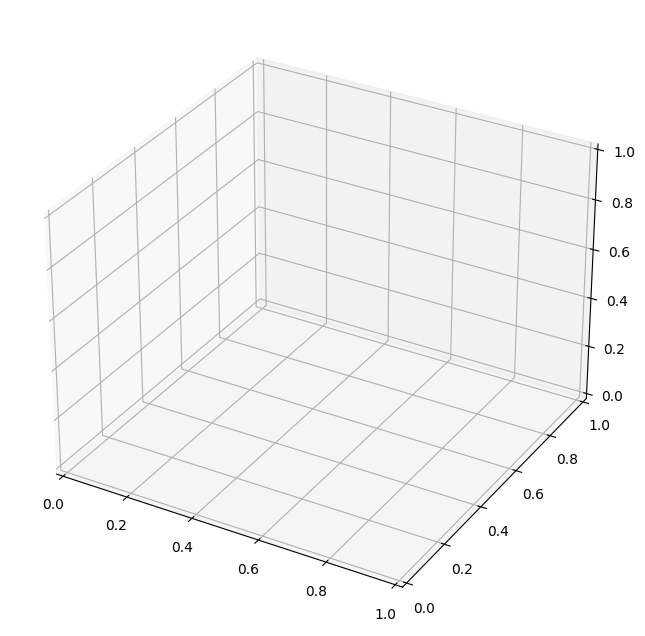

In [12]:


def plot_error_surface(df, TAU_fixed):
    df_sorted = df.sort_values(['NC_K'])
    NC_Ks = np.sort(df['NC_K'].values).reshape(-1)
    SIGMA_Ks = np.sort(df['SIGMA_K'].values).reshape(-1)
    TAUs = np.sort(df['TAU'].values).reshape(-1)
    errors = df['error'].values.reshape(-1, 1)
    print(NC_Ks.shape, SIGMA_Ks.shape, TAUs.shape, errors.shape)
    
    # Create the interpolation function
    points = np.array([df['NC_K'], df['SIGMA_K'], df['TAU']]).T
    interpf = LinearNDInterpolator(points, errors.reshape(-1), )
    # Set up the grid
    NC_Ks_mesh, SIGMA_Ks_mesh = np.meshgrid(NC_Ks, SIGMA_Ks)
    grid = np.array([NC_Ks_mesh.ravel(), SIGMA_Ks_mesh.ravel(), TAU_fixed * np.ones_like(NC_Ks_mesh.ravel())]).T
    # Interpolate the errors on the grid
    interp_vals = interpf(grid).reshape(NC_Ks_mesh.shape)
    # Interpolate the errors on the grid
    interp_vals = griddata((df['NC_K'], df['SIGMA_K'], df['TAU']), errors, (NC_Ks_mesh, SIGMA_Ks_mesh, TAU_fixed*np.ones_like(NC_Ks_mesh)), method='linear').reshape(NC_Ks_mesh.shape)
    
    print(interp_vals)
    # Create the plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(NC_Ks_mesh, SIGMA_Ks_mesh, interp_vals, cmap='coolwarm', rstride=1, cstride=1, linewidth=0, antialiased=False)
    ax.set_xlabel('NC_K')
    ax.set_ylabel('SIGMA_K')
    ax.set_zlabel('error')
    ax.set_title(f'Error surface at TAU={TAU_fixed:.5f}')
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
    return fig

fig = plot_error_surface(df, 0.000525)

Index(['SoluteName', 'NC_K', 'SIGMA_K', 'TAU', 'error'], dtype='object')


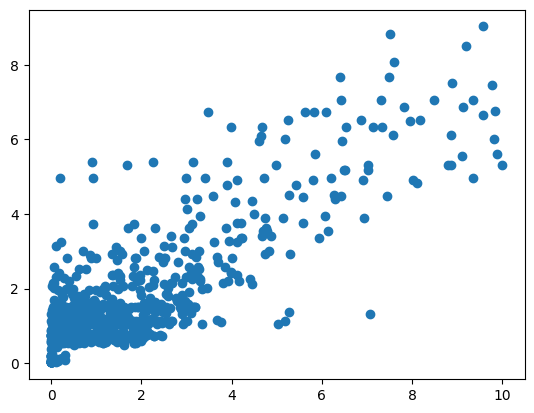

In [ ]:
print(df2.columns)
X = df2[['NC_K', 'SIGMA_K', 'TAU']].to_numpy()
Y = df2['error'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

reg =GradientBoostingRegressor(n_estimators=1000, max_depth=2, random_state=0)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)
plt.scatter(y_test, reg.predict(X_test))


In [26]:

groups = df[df['Solvent']=='water'].groupby(['NC_K', 'SIGMA_K', 'TAU'])
print(len(groups))
# get the number of unique groups
# using the groups split of the dataframe so that unique combos of NC_K, SIGMA_K, and TAU are in each group
split = 0.9
# get the unique groups
groups = df.groupby(['NC_K', 'SIGMA_K', 'TAU'])
# get the indicies of the groups
indicies = [np.array(i) for i in groups.indices.values()]
print(indicies)
# get the number of groups
num_groups = len(indicies)
# get the number of groups to use for training
num_train_groups = int(num_groups*split)
print(num_train_groups)
# get the indicies of the groups to use for training
train_indicies = np.random.choice(indicies, size=num_train_groups, replace=False)
train_indicies = np.concatenate(train_indicies.flatten())
# get the indicies of the groups to use for testing
test_indicies = np.array([i for i in np.concatenate(indicies) if i not in train_indicies])
train_df = df.iloc[train_indicies]
test_df = df.iloc[test_indicies]

X_train = get_X_solute(train_df)
X_test = get_X_solute(test_df)
y_train = train_df['error'].to_numpy()
y_test = test_df['error'].to_numpy()


# print out the shape of the training data and the training labels. Nice retro looking print statment
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')
n_observations_train = X_train.shape[0]
n_features_train = X_train.shape[1]
n_observations_test = X_test.shape[0]
n_features_test = X_test.shape[1]

print('TRAINING SET DETAILS')
print(f'Number of observations: {n_observations_train}')
print(f'Number of features: {n_features_train}')

print('TESTING SET DETAILS')
print(f'Number of observations: {n_observations_test}')
print(f'Number of features: {n_features_test}')

181
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24], dtype=int64), array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49], dtype=int64), array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74], dtype=int64), array([75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91,
       92, 93, 94, 95, 96, 97, 98, 99], dtype=int64), array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124],
      dtype=int64), array([125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149],
      dtype=int64), array([150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174],
      dtype=int64),

ValueError: a must be 1-dimensional

In [14]:
from sklearn.preprocessing import StandardScaler
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [15]:
print(X_train.shape)
# send the training data to gpu
X_train = torch.from_numpy(X_train).float().cuda().reshape(-1, n_features_train)
y_train = torch.from_numpy(y_train).float().cuda().reshape(-1, 1)
X_test = torch.from_numpy(X_test).float().cuda().reshape(-1, n_features_train)

(5618, 57)


In [16]:
# lets wrap a NN model around ctl.model.NN 
# we will feed the first 51 features into 1 NN
# then we will feed the remaining features into another NN. 
from torch import nn
import torch
class decomposed_model(nn.Module):
    def __init__(self, n_inputs1=53, n_inputs2=3, n_outputs1=3, n_outputs2=1, layers1=5, layer_size1=10, layers2=5, layer_size2=10):
        super(decomposed_model, self).__init__()
        self.layers1 = layers1
        self.layer_size1 = layer_size1
        self.layers2 = layers2
        self.layer_size2 = layer_size2
        self.model1 = ctl.model.NN(layers=layers1, layer_size=layer_size1, n_inputs = n_inputs1, n_outputs = n_outputs1)
        self.model2 = ctl.model.NN(layers=layers2, layer_size=layer_size2, n_inputs = n_inputs2 + n_outputs1, n_outputs = n_outputs2)
        
    def forward(self, x):
        x1 = x[:, :53]
        x2 = x[:, 53:]
        y1 = self.model1.forward(x1)
        # append the y1 values to the x2 values
        x2 = torch.cat((x2, y1), dim=1)
        y2 = self.model2.forward(x2)
        return y2
    
    def n_params(self):
        # get the number of parameters in the first model using the state_dict
        n_params1 = sum(p.numel() for p in self.model1.parameters() if p.requires_grad)
        # get the number of parameters in the second model using the state_dict
        n_params2 = sum(p.numel() for p in self.model2.parameters() if p.requires_grad)
        return n_params1 + n_params2

In [65]:
model = ctl.model.NN(n_inputs=n_features_train, n_outputs=1, layer_size=40, layers=2)
#model = decomposed_model(n_inputs1=53, n_inputs2=X_train.shape[1]-53, n_outputs1=3, n_outputs2=1, layers1=5, layer_size1=10, layers2=1, layer_size2=50)

In [66]:
# lets brute force calculate the number of parameters in the model using the attributes of the model
def get_n_parmas(model):
    n_params = 0
    for param in model.parameters():
        n_params += param.numel()
    return n_params
get_n_parmas(model)

5641

In [67]:
losses = ctl.model.run_Pytorch(model, X_train, y_train, n_epochs=1001, batch_size=4, learning_rate=0.001)

EPOCH :  0 , dt:  2.357653856277466 seconds, losses : 0.4459884464740753
EPOCH :  10 , dt:  23.064534664154053 seconds, losses : 0.07436501979827881
EPOCH :  20 , dt:  23.084528923034668 seconds, losses : 0.025344345718622208
EPOCH :  30 , dt:  23.12339496612549 seconds, losses : 0.0205124132335186
EPOCH :  40 , dt:  23.108481407165527 seconds, losses : 0.058539535850286484
EPOCH :  50 , dt:  23.120965242385864 seconds, losses : 0.011870108544826508
EPOCH :  60 , dt:  23.124828577041626 seconds, losses : 0.01767968386411667
EPOCH :  70 , dt:  23.083309650421143 seconds, losses : 0.008475669659674168
EPOCH :  80 , dt:  23.151103973388672 seconds, losses : 0.019473960623145103
EPOCH :  90 , dt:  23.107609272003174 seconds, losses : 0.010841047391295433
EPOCH :  100 , dt:  23.090267658233643 seconds, losses : 0.0047509875148534775
EPOCH :  110 , dt:  23.125666856765747 seconds, losses : 0.013144264928996563
EPOCH :  120 , dt:  23.13308310508728 seconds, losses : 0.0016957720508798957
EPOC

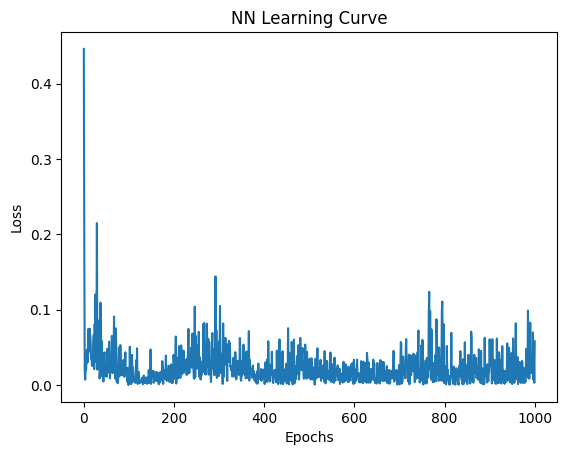

In [68]:
import matplotlib.pyplot as plt
# create a professional learning curve plot function
def plot_learning_curve(losses, title=None, save=False, filename=None):
    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    if title:
        plt.title(title)
    if save:
        plt.savefig(filename)
plot_learning_curve(losses, title='NN Learning Curve', save=True, filename='NN_learning_curve.png')

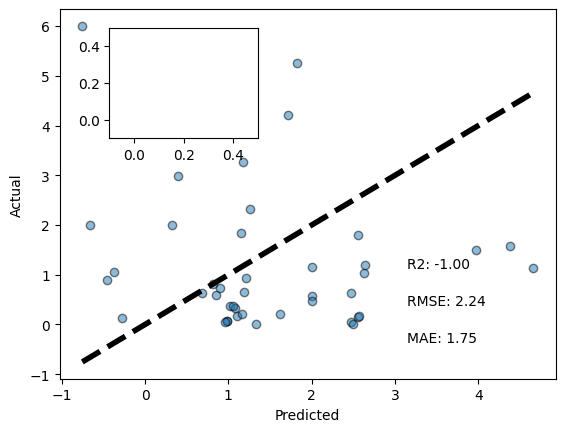

In [75]:
#model = model.to('cuda')
model = loadmodel
# X_train = torch.from_numpy(X_train).float().reshape(-1, n_features_train)
# y_train = torch.from_numpy(y_train).float().reshape(-1, 1)
# X_test = torch.from_numpy(X_test).float().reshape(-1, n_features_train)
# y_test = torch.from_numpy(y_test).float().reshape(-1, 1).cpu().detach().numpy()
# X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
pred = model(X_test).cpu().detach().numpy()
# put the rmse, mse and r2 in the bottom left corner of the plot
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(np.mean((pred - y_test.detach().cpu().numpy())**2))
r2 = r2_score(y_test, pred)
plt.text(0.7, 0.1, f'MAE: {mae:.2f}', transform=plt.gca().transAxes)
plt.text(0.7, 0.2, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes)  
plt.text(0.7, 0.3, f'R2: {r2:.2f}', transform=plt.gca().transAxes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.scatter(pred, y_test, edgecolors='k', alpha=0.5)
plt.plot([pred.min(), pred.max()], [pred.min(), pred.max()], 'k--', lw=4)
# lets put an inset in the top left corner of the plot of this parity plot
# zoomed in between 0 and 0.5
ax = plt.gca()
axins = ax.inset_axes([0.1, 0.65, 0.3, 0.3])
axins.scatter(pred, y_test,  edgecolors='k', alpha=0.5)
axins.plot([pred.min(), pred.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
axins.set_xlim(-0.1, 0.5)
axins.set_ylim(-0.1, 0.5)
plt.savefig('NN_parity_plot.png')

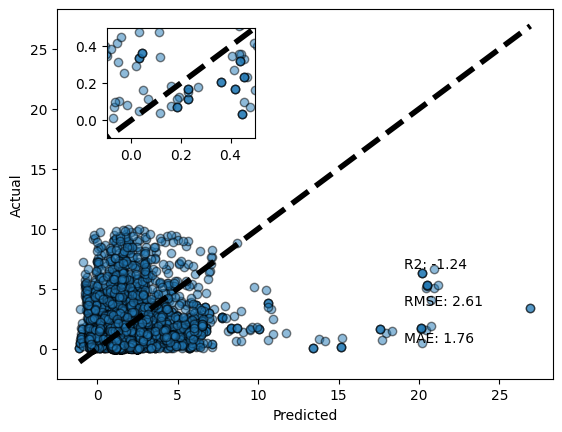

In [76]:
# plot the model against all the data 
# we will use the model to predict the y values for the training and testing data

pred = model(X_train).cpu().detach().numpy()
# put the rmse, mse and r2 in the bottom left corner of the plot
mae = mean_absolute_error(y_train, pred)
rmse = np.sqrt(np.mean((pred - y_train.detach().cpu().numpy())**2))
r2 = r2_score(y_train, pred)
plt.text(0.7, 0.1, f'MAE: {mae:.2f}', transform=plt.gca().transAxes)
plt.text(0.7, 0.2, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes)  
plt.text(0.7, 0.3, f'R2: {r2:.2f}', transform=plt.gca().transAxes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.scatter(pred, y_train, edgecolors='k', alpha=0.5)
plt.plot([pred.min(), pred.max()], [pred.min(), pred.max()], 'k--', lw=4)
# lets put an inset in the top left corner of the plot of this parity plot
# zoomed in between 0 and 0.5
ax = plt.gca()
axins = ax.inset_axes([0.1, 0.65, 0.3, 0.3])
axins.scatter(pred, y_train,  edgecolors='k', alpha=0.5)
axins.plot([pred.min(), pred.max()], [pred.min(), pred.max()], 'k--', lw=4)
axins.set_xlim(-0.1, 0.5)
axins.set_ylim(-0.1, 0.5)
plt.savefig('NN_parity_plot.png')

In [94]:
# save the model parameters attributes to the name of the file and save the state dict 
# also include the time in dd-mm-yy_hh-mm-ss format
import time
import os
import pickle
import datetime
now = datetime.datetime.now()
# get the model attributes and create a file string. we only want attributes like layers, layer_size, n_inputs, n_outputs
model_attributes = [attr for attr in dir(model) if not callable(getattr(model, attr)) and not attr.startswith("__")]
model_string = ''
for attr in model_attributes:
    if attr in ['layers', 'layer_size', 'n_inputs', 'n_outputs']:
        model_string += f'{attr}_{getattr(model, attr)}_'
print(model_string)
filename = f'{model_string}{now.strftime("%d-%m-%Y_%H-%M-%S")}.pkl'
# save the model parameters
with open(filename, 'wb') as f:
    model = model.to('cpu')
    pickle.dump(model.state_dict(), f)
print(filename)


layer_size_40_layers_2_n_inputs_57_n_outputs_1_
layer_size_40_layers_2_n_inputs_57_n_outputs_1_02-03-2023_20-07-44.pkl


In [65]:
# lets load C:\Users\efons\Desktop\EMA\layer_size_30_layers_2_n_inputs_57_n_outputs_1_28-02-2023_00-21-57.pkl . Use the data in the file name to create the model
# then load the state dict into the model
import pickle
import torch
filename = '/blue/hennig/ericfonseca/NASA/VASPsol/Truhlar_Benchmarks/VaspPysol/notebooks/models/layer_size_60_layers_2_n_inputs_57_n_outputs_1_03-03-2023_13-59-10.pkl'
layers = int(filename.split('layers_')[1].split('_')[0])
layer_size = int(filename.split('layer_size_')[1].split('_')[0])
n_inputs = int(filename.split('n_inputs_')[1].split('_')[0])
n_outputs = int(filename.split('n_outputs_')[1].split('_')[0])
loadmodel = ctl.model.NN(layers=layers, layer_size=layer_size, n_inputs=n_inputs, n_outputs=n_outputs)
with open(filename, 'rb') as f:
    loadmodel.load_state_dict(pickle.load(f))
#model = loadmodel.to('cuda')

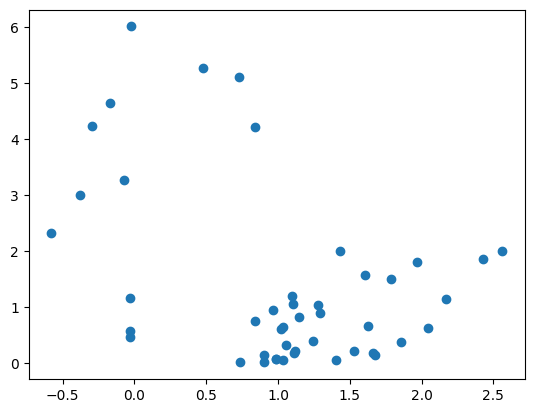

In [34]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train.cpu().detach().numpy(), y_train.cpu().detach().numpy())
pred = reg.predict(X_test.cpu().detach().numpy())
plt.scatter(pred, y_test)


/home/ericfonseca/miniconda3/envs/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


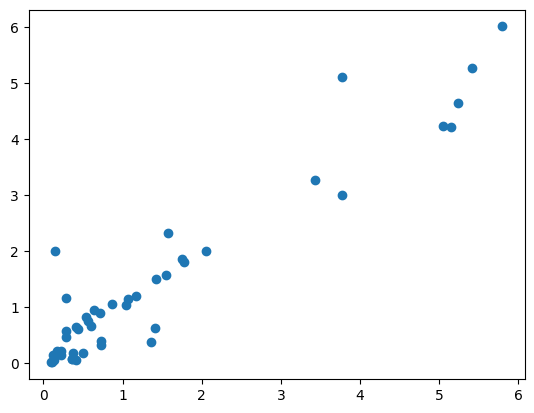

In [35]:
from sklearn.svm import SVR
reg = SVR().fit(X_train.cpu().detach().numpy(), y_train.cpu().detach().numpy())
pred = reg.predict(X_test.cpu().detach().numpy())
plt.scatter(pred, y_test)

In [37]:
# which molecules are the most difficult to predict?
# get the mean error for each molecule
resultdf = df
resultdf['error'] = resultdf['error'].abs()
result_X = get_X_solute(resultdf)
result_X = scaler.transform(result_X)
result_X = torch.from_numpy(result_X).float().reshape(-1, n_features_train)
resultdf['pred'] = model(result_X).cpu().detach().numpy()
resultdf['pred_error'] = np.abs(resultdf['pred'] - resultdf['error'])
# get the molecules with the largest error
resultdf.sort_values(by='pred_error', ascending=False).head(10)

,Unnamed: 0,Solvent,FileHandle,NC_K,SIGMA_K,TAU,Solvation_Energy,Total_Energy,No.,SoluteName,...,sigma_solvent_44,sigma_solvent_45,sigma_solvent_46,sigma_solvent_47,sigma_solvent_48,sigma_solvent_49,sigma_solvent_50,default_error,pred,pred_error
3871,825,water,0008noc,0.003667,0.911111,0.000525,-0.280130,-139.974650,2100,n-octane,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.255968,-0.204331,9.554129
794,167,water,0153flu,0.003000,1.200000,0.000670,-0.442392,-24.381697,2238,fluoromethane,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.597405,0.573926,9.407634
18583,3616,water,0036tol,0.003333,1.000000,0.000525,-0.428002,-93.087376,2126,toluene,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.119705,-0.294070,9.273796
1699,378,water,0139thi,0.004000,0.866667,0.000010,-0.532625,-80.340019,2225,thiophenol,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000740,0.558596,9.173736
22375,4294,water,0053phe,0.000700,1.500000,0.000525,-0.663170,-83.348366,2142,phenol,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.902688,-0.292902,8.965603
14895,2799,water,0076but,0.004000,0.911111,0.000525,-0.581519,-73.095849,2163,2-butanone,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.556505,0.814348,8.955480
18625,3623,water,0036tol,0.003250,1.000000,0.000525,-0.410630,-93.070004,2126,toluene,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.119705,-0.275194,8.854322
830,176,water,0153flu,0.003000,1.200000,0.001000,-0.413843,-24.353148,2238,fluoromethane,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.597405,0.650286,8.672934
26530,5211,water,0086eth,0.000700,1.500000,0.000525,-0.686098,-47.431527,2173,aceticacid,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.540563,0.549239,8.572181
200,40,water,0157flu,0.002000,1.200000,0.000670,-0.418274,-76.685575,2240,fluorobenzene,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.983698,0.311741,8.553657


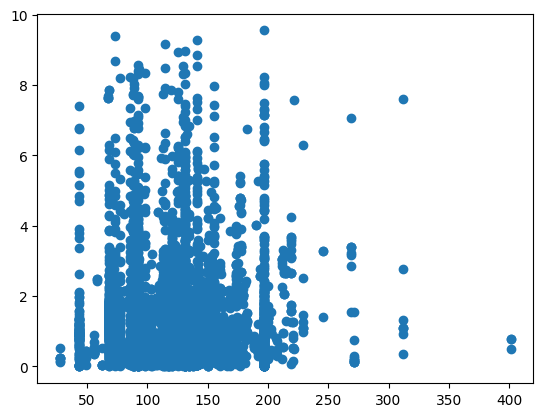

In [38]:
plt.scatter(resultdf['area_solute'], resultdf['pred_error'])

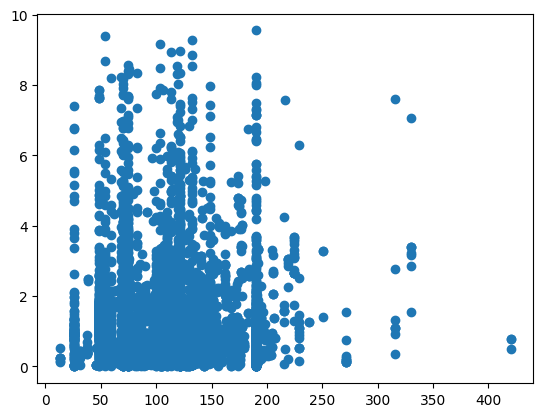

In [39]:
plt.scatter(resultdf['volume_solute'], resultdf['pred_error'])

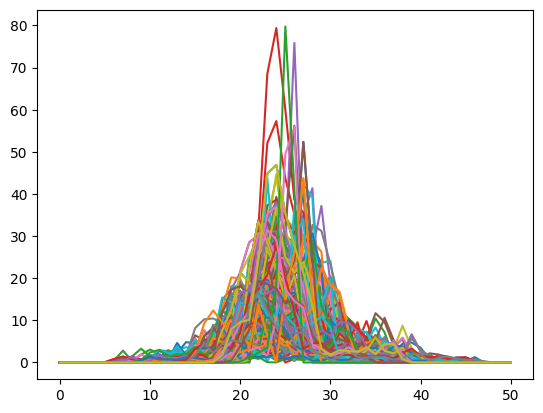

In [40]:
# lets all unique sigma_solute values
sig_sol_cols = [col for col in resultdf.columns if 'sigma_solute' in col]
sig_sols_unique = resultdf.drop_duplicates('FileHandle')[sig_sol_cols]
# plot them 
for i in range(len(sig_sols_unique)):
    plt.plot(sig_sols_unique.iloc[i][sig_sol_cols].to_numpy())

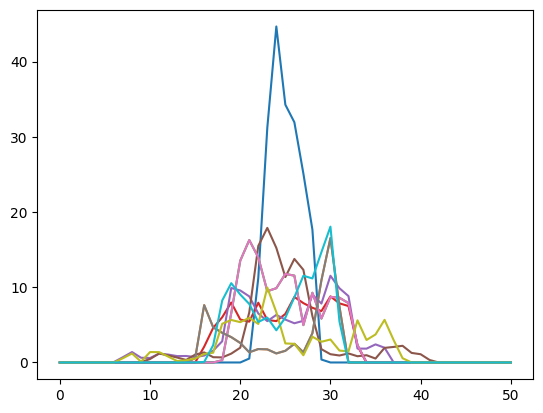

In [41]:
# plot the sigma profiles of the 10 most difficult molecules to predict
for i in range(10):
    plt.plot(resultdf.sort_values(by='pred_error', ascending=False).iloc[i][sig_sol_cols].to_numpy())
    

,Unnamed: 0,Solvent,FileHandle,NC_K,SIGMA_K,TAU,Solvation_Energy,Total_Energy,No.,SoluteName,...,sigma_solvent_44,sigma_solvent_45,sigma_solvent_46,sigma_solvent_47,sigma_solvent_48,sigma_solvent_49,sigma_solvent_50,default_error,pred,pred_error
27973,5548,water,0407tet,0.0025,0.6,0.000525,-0.081502,-34.201214,2315,"1,1,1,2-tetrachloroethane",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.729436,0.306140,0.423297
23244,4432,water,0060dim,0.0025,0.6,0.000525,-0.065128,-46.437259,2148,dimethylether,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.418148,1.294700,0.876552
15694,2977,water,0052pen,0.0025,0.6,0.000525,-0.163988,-96.635209,2141,1-pentanol,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.688437,1.547638,0.859202
12584,2335,water,0066dim,0.0025,0.6,0.000525,-0.108418,-85.616988,2154,"1,2-dimethoxyethane",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.339881,4.897860,2.557979
28075,5586,water,0147met,0.0025,0.6,0.000525,-0.194628,-74.963524,2233,2-methoxyethanamine,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.061878,2.813349,0.751471
28229,5642,water,0027pen,0.0025,0.6,0.000525,0.003867,-81.686644,2117,1-pentene,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.570827,0.216480,1.354347
19722,3846,water,0197bro,0.0025,0.6,0.000525,-0.000739,-22.754814,2267,bromotrifluoromethane,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.807041,3.060860,1.253819
28257,5652,water,0100met,0.0025,0.6,0.000525,-0.138310,-129.040780,2187,methylhexanoate,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.699429,0.822043,0.122614
27088,5373,water,0184bro,0.0025,0.6,0.000525,-0.046179,-71.511023,2263,1-bromobutane,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.654888,-0.140345,0.795232
11069,2020,water,n019,0.0025,0.6,0.000525,-0.242210,-51.361415,2366,ethylperoxide,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.265363,0.656587,0.391224


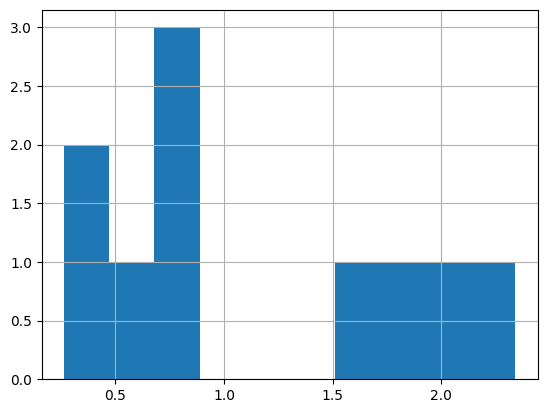

In [42]:
def rejection_sampling(vector, samples=100):
    indicies = np.arange(len(vector))
    # fit a gaussian kernel to the data
    from sklearn.neighbors import KernelDensity
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(vector.reshape(-1, 1))
    # create a vector of each points probability
    logprob = kde.score_samples(vector.reshape(-1, 1))
    p = np.exp(logprob)
    # normalize the probabilities
    p = p / p.sum()

    output = []
    for sample in range(samples):
        # use the probability to sample the data
        sample = np.random.choice(indicies, p=p)
        # add the sample to the vector
        output.append(sample)
    return output
d = resultdf.drop_duplicates('FileHandle')
train_mols = rejection_sampling(d['error'].to_numpy(), samples=10)
d.iloc[train_mols]['error'].hist()
d.iloc[train_mols]

In [45]:
# create an optimizer object with inputs of NC_K, SIGMA_K, and TAU and will use defaultdf to compute the error
from scipy.optimize import minimize
NC_K_default = 0.0025
SIGMA_K_default = 0.6
TAU_default = 0.000525
defaultdf = d[(d['NC_K'] == NC_K_default) & (d['SIGMA_K'] == SIGMA_K_default) & (d['TAU'] == TAU_default)]
def compute_error(inputs):
    NC_K = inputs[0]
    SIGMA_K = inputs[1]
    TAU = inputs[2]
    # replace the NC_K, SIGMA_K, and TAU columns with the new values
    df = defaultdf.copy()
    df['NC_K'] = NC_K
    df['SIGMA_K'] = SIGMA_K
    df['TAU'] = TAU
    X = get_X_solute(df)
    X = scaler.transform(X)
    X = torch.from_numpy(X).float().reshape(-1, n_features_train)
    pred = model(X).cpu().detach().numpy()
    return pred.mean()

# minimize the error given bounds on the inputs
res = minimize(compute_error, [NC_K_default, SIGMA_K_default, TAU_default], bounds=[(0.001, 0.005), (0, 2), (0.000001, 0.001)], tol=1e-10)
res

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.9809959
        x: [ 1.508e-03  6.000e-01  1.000e-06]
      nit: 5
      jac: [ 0.000e+00  0.000e+00  2.444e+02]
     nfev: 36
     njev: 9
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [46]:
# lets do a light particle swarm optimization
from pyswarm import pso
def compute_error(inputs):
    NC_K = inputs[0]
    SIGMA_K = inputs[1]
    TAU = inputs[2]
    EPS = 78.36
    # replace the NC_K, SIGMA_K, and TAU columns with the new values
    df = defaultdf.copy()
    df['NC_K'] = NC_K
    df['SIGMA_K'] = SIGMA_K
    df['TAU'] = TAU
    df['eps'] = EPS
    X = get_X_solute(df)
    X = scaler.transform(X)
    X = torch.from_numpy(X).float().reshape(-1, n_features_train)
    pred = model(X).cpu().detach().numpy()
    return pred.mean()
model = model.to('cpu')

# minimize the error given bounds on the inputs. use 4 workers to speed up the process and make sure to display the progress
res = pso(compute_error, [0.001, 0, 0.000001], [0.005, 1.5, 0.001], swarmsize=1000, maxiter=10, minstep=1e-10, minfunc=1e-10,debug=True)
res[0], res[1]

No constraints given.
New best for swarm at iteration 1: [1.95604423e-03 1.47421878e+00 1.00000000e-06] 0.8863889575004578
Best after iteration 1: [1.95604423e-03 1.47421878e+00 1.00000000e-06] 0.8863889575004578
New best for swarm at iteration 2: [1.88545565e-03 1.50000000e+00 1.00000000e-06] 0.8857985138893127
New best for swarm at iteration 2: [1.86114061e-03 1.50000000e+00 1.00000000e-06] 0.8856144547462463
New best for swarm at iteration 2: [1.75304964e-03 1.50000000e+00 1.00000000e-06] 0.8854131102561951
New best for swarm at iteration 2: [1.78554788e-03 1.50000000e+00 1.00000000e-06] 0.8852835297584534
Best after iteration 2: [1.78554788e-03 1.50000000e+00 1.00000000e-06] 0.8852835297584534
New best for swarm at iteration 3: [1.80061016e-03 1.50000000e+00 1.00000000e-06] 0.8852755427360535
New best for swarm at iteration 3: [1.79948267e-03 1.50000000e+00 1.00000000e-06] 0.8852736949920654
New best for swarm at iteration 3: [1.79546556e-03 1.50000000e+00 1.00000000e-06] 0.8852716

(array([1.78848277e-03, 1.49415962e+00, 1.00000000e-06]), 0.8852463)

0.6178367137908936
0.001 0.0


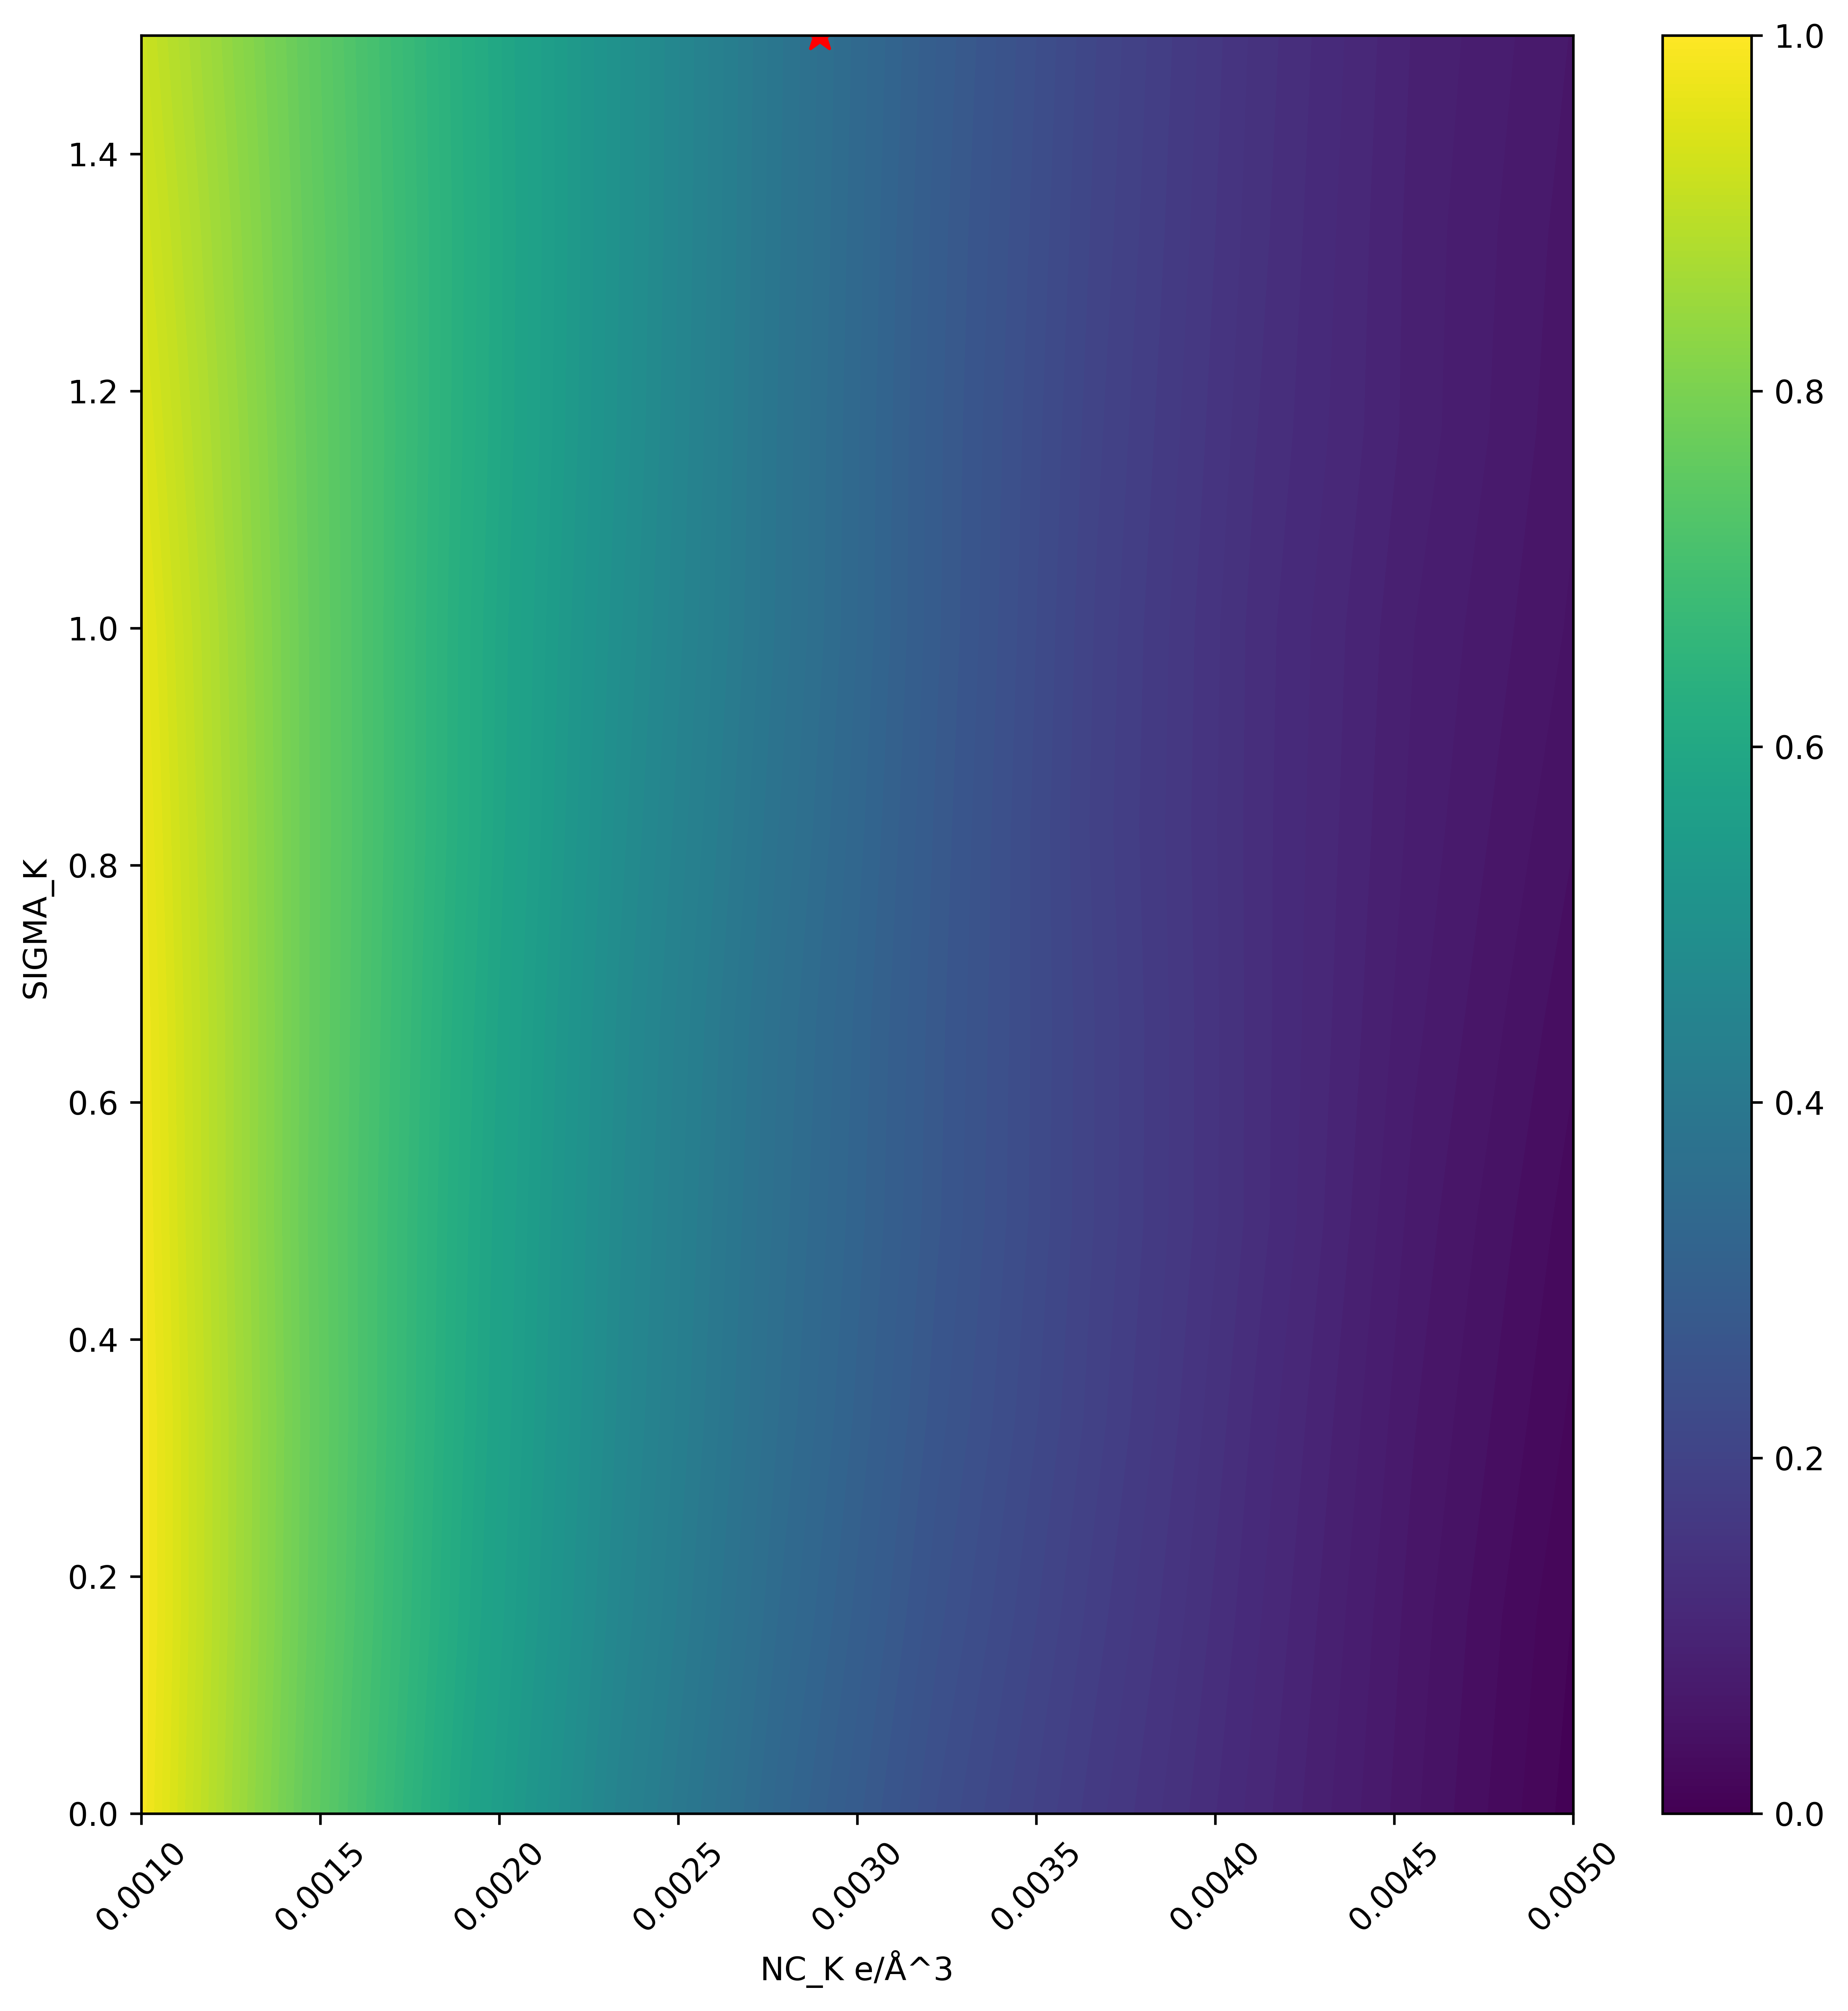

In [63]:

# use compute error to construc an error surface on NC_K and SIGMA_K using default TAU
fig, ax = plt.subplots(figsize=(10, 10), dpi=600)
NC_Ks = np.linspace(0.001, 0.005, 10)
SIGMA_Ks = np.linspace(0.0, 1.5, 10)
errors = np.zeros((len(NC_Ks), len(SIGMA_Ks)))
for i, NC_K in enumerate(NC_Ks):
    for j, SIGMA_K in enumerate(SIGMA_Ks):
        errors[i, j] = compute_error([NC_K, SIGMA_K, 1e-4])
        if errors[i, j] > 1.5:
            errors[i, j] = 1.5
plt.contourf(NC_Ks, SIGMA_Ks, errors, levels=100)
# put a star at the minimum
plt.scatter(res[0][0], res[0][1], marker='*', color='red', s=100)
# rotate x axis labels 45 degrees
plt.xticks(rotation=45)
plt.xlabel('NC_K e/Å^3')
plt.ylabel('SIGMA_K ')
# log scale colorbar
# print the smallest error in the plot
print(errors.min())
# where is the smallest error?
min_loc = np.where(errors == errors.min())
plt.colorbar()
# print the NC_K and SIGMA_K values at the smallest error
print(NC_Ks[0], SIGMA_Ks[0])




In [64]:
# lets use brute force to find the best parameters. lets create a grid of NC_K, SIGMA_K, and TAU values
NC_Ks = np.linspace(0.001, 0.005, 10)
SIGMA_Ks = np.linspace(0.2, 1, 10)
TAUs = np.linspace(0.0005, 0.001, 20)
errors = np.zeros((len(NC_Ks), len(SIGMA_Ks), len(TAUs)))
job_array = []
for i, NC_K in enumerate(NC_Ks):
    for j, SIGMA_K in enumerate(SIGMA_Ks):
        for k, TAU in enumerate(TAUs):
            job_array.append(dask.delayed(compute_error([NC_K, SIGMA_K, TAU])))

# compute the errors
errors = np.array(dask.compute(*job_array))
print(errors)
# find the minimum error
errors.min()
# where is the minimum error?
min_loc = np.where(errors == errors.min())
# lets make a 3d grid of the errors and the inputs
NC_K_grid = np.zeros((len(NC_Ks), len(SIGMA_Ks), len(TAUs)))
SIGMA_K_grid = np.zeros((len(NC_Ks), len(SIGMA_Ks), len(TAUs)))
TAU_grid = np.zeros((len(NC_Ks), len(SIGMA_Ks), len(TAUs)))
error_grid = np.zeros((len(NC_Ks), len(SIGMA_Ks), len(TAUs)))
for i, NC_K in enumerate(NC_Ks):
    for j, SIGMA_K in enumerate(SIGMA_Ks):
        for k, TAU in enumerate(TAUs):
            NC_K_grid[i, j, k] = NC_K
            SIGMA_K_grid[i, j, k] = SIGMA_K
            TAU_grid[i, j, k] = TAU
            error_grid = errors.reshape((len(NC_Ks), len(SIGMA_Ks), len(TAUs)))
min_loc = np.where(error_grid == error_grid.min())
print(NC_K_grid[min_loc], SIGMA_K_grid[min_loc], TAU_grid[min_loc])

            

[0.8423134  0.83865994 0.83515495 ... 0.63590467 0.63395536 0.6319462 ]
[0.001] [1.] [0.001]


MovieWriter stderr:
convert: unexpected end-of-file `-': No such file or directory @ error/rgb.c/ReadRGBImage/243.
convert: no images defined `animation.gif' @ error/convert.c/ConvertImageCommand/3235.



CalledProcessError: Command '['convert', '-size', '640x480', '-depth', '8', '-delay', '10.0', '-loop', '0', 'rgba:-', '-layers', 'OptimizePlus', 'animation.gif']' returned non-zero exit status 1.

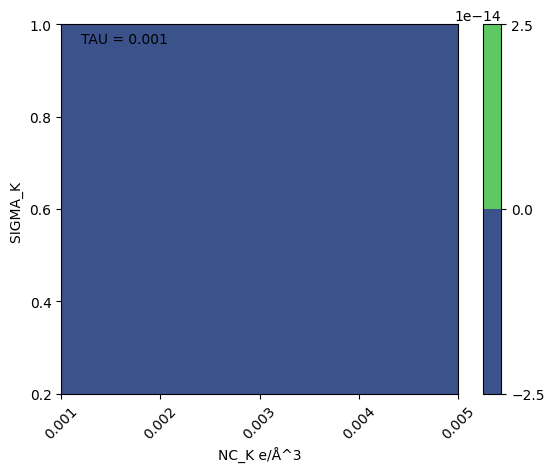

In [30]:
# lets make a animation of the error surface as we change TAU
from matplotlib import animation, rc
from IPython.display import HTML
# initialize all the variables
NC_Ks = np.linspace(0.001, 0.005, 100)
SIGMA_Ks = np.linspace(0.2, 1, 100)
TAUs = np.linspace(0.0005, 0.001, 20)
dtau = TAUs[1] - TAUs[0]
errors = np.zeros((len(NC_Ks), len(SIGMA_Ks)))

# create a figure
fig = plt.figure()
# create an axis
ax = plt.axes(xlim=(NC_Ks.min(), NC_Ks.max()), ylim=(SIGMA_Ks.min(), SIGMA_Ks.max()))
# create a contour plot
contour = ax.contourf(NC_Ks, SIGMA_Ks, errors)
# create a colorbar
cbar = plt.colorbar(contour)
# create a text box to display the current TAU
tau_text = ax.text(0.05, 0.95, '', transform=ax.transAxes)

# create a init function to initialize the contour plot
def init():
    contour = ax.contourf(NC_Ks, SIGMA_Ks, errors)
    tau_text.set_text('TAU = ' + str(0.001))
    plt.xticks(rotation=45)
    plt.xlabel('NC_K e/Å^3')
    plt.ylabel('SIGMA_K ')
    # make the labels look nice. figure worthy for  a paper
    plt.rcParams['font.size'] = 20
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 20
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    # must return a sequence of artists objects
    return contour, tau_text

# create a function to update the contour plot
def update(i):
    TAU = 0.0001 + i*dtau
    for j, NC_K in enumerate(NC_Ks):
        for k, SIGMA_K in enumerate(SIGMA_Ks):
            errors[j, k] = compute_error([NC_K, SIGMA_K, TAU])
            if errors[j, k] > 1.5:
                errors[j, k] = 1.5
    contour = ax.contourf(NC_Ks, SIGMA_Ks, errors)
    plt.xticks(rotation=45)
    tau_text.set_text('TAU = ' + str(TAU) + ' eV/Å^3')
    # must return a sequence of artists objects
    return contour, tau_text

# create an animation object
anim = animation.FuncAnimation(fig, update, init_func=init, frames=40, interval=100)
# display the animation
#HTML(anim.to_html5_video())
# save as a gif
anim.save('animation.gif', writer='imagemagick', fps=10)

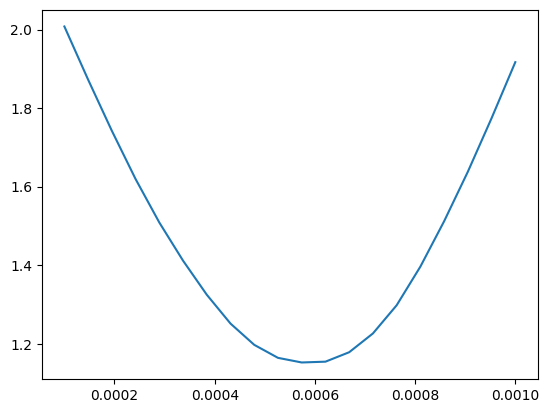

In [53]:
# for a fixed NC_K and SIGMA_K, plot the error surface for TAU
NC_K = 0.0025
SIGMA_K = 0.6
TAUs = np.linspace(0.0001, 0.001, 20)
errors = np.zeros(len(TAUs))
for i, TAU in enumerate(TAUs):
    errors[i] = compute_error([NC_K, SIGMA_K, TAU])
plt.plot(TAUs, errors)

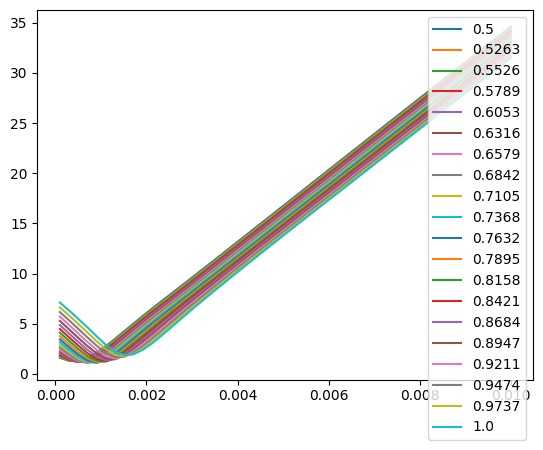

In [54]:
# do the same thing but for SIGMA_K
SIGMA_Ks = np.linspace(0.5, 1.0, 20)
TAUs = np.linspace(0.0001, 0.01, 50)
for SIGMA_K in SIGMA_Ks:
    errors = np.zeros(len(TAUs))
    for i, TAU in enumerate(TAUs):
        errors[i] = compute_error([NC_K, SIGMA_K, TAU])
    plt.plot(TAUs, errors, label=SIGMA_K.round(4))
plt.legend(loc='upper right')

In [55]:
from scipy.optimize import minimize
NC_K_default = 0.0025
SIGMA_K_default = 0.6
TAU_default = 0.000525
res = minimize(compute_error, x0=[NC_K_default, SIGMA_K_default, TAU_default], options={'disp': True}, tol=1e-4)
res

         Current function value: 1.066714
         Iterations: 10
         Function evaluations: 248
         Gradient evaluations: 59


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1.0667141675949097
        x: [ 3.331e-03  6.001e-01  8.783e-04]
      nit: 10
      jac: [ 0.000e+00  8.000e+00  0.000e+00]
 hess_inv: [[ 2.077e-07 -7.468e-09  1.275e-08]
            [-7.468e-09  1.278e-06  6.081e-07]
            [ 1.275e-08  6.081e-07  3.909e-07]]
     nfev: 248
     njev: 59

In [273]:
# find the top 10 molecules with NC_K, SIGMA_K, and TAU values closest to the optimal values
d = resultdf.drop_duplicates('FileHandle')
d['NC_K_diff'] = np.abs(d['NC_K'] - res.x[0])/res.x[0]
d['SIGMA_K_diff'] = np.abs(d['SIGMA_K'] - res.x[1])/res.x[1]
d['TAU_diff'] = np.abs(d['TAU'] - res.x[2])/res.x[2]
d['diff'] = d['NC_K_diff'] + d['SIGMA_K_diff'] + d['TAU_diff']
d.sort_values(by='diff').iloc[:10]


C:\Users\efons\AppData\Local\Temp\ipykernel_6652\2595521117.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['NC_K_diff'] = np.abs(d['NC_K'] - res.x[0])/res.x[0]
C:\Users\efons\AppData\Local\Temp\ipykernel_6652\2595521117.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['SIGMA_K_diff'] = np.abs(d['SIGMA_K'] - res.x[1])/res.x[1]
C:\Users\efons\AppData\Local\Temp\ipykernel_6652\2595521117.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,Unnamed: 0,Solvent,FileHandle,NC_K,SIGMA_K,TAU,Solvation_Energy,Total_Energy,No.,SoluteName,...,sigma_solvent_47,sigma_solvent_48,sigma_solvent_49,sigma_solvent_50,pred,pred_error,NC_K_diff,SIGMA_K_diff,TAU_diff,diff
3110,3110,water,0031pro,0.0025,0.6,0.000525,-0.113237,-39.938235,2121,propyne,...,0.0,0.0,0.0,0.0,2.060914,0.240331,0.318043,0.032142,0.439307,0.789492
3620,3620,water,0121met,0.0025,0.6,0.000525,-0.141751,-88.061791,2207,4-methylpyridine,...,0.0,0.0,0.0,0.0,1.744880,0.073658,0.318043,0.032142,0.439307,0.789492
3625,3625,water,0211tri,0.0025,0.6,0.000525,-0.237591,-65.040775,2279,"1,1,1-trifluoropropan-2-ol",...,0.0,0.0,0.0,0.0,0.749511,0.569338,0.318043,0.032142,0.439307,0.789492
3629,3629,water,0160chl,0.0025,0.6,0.000525,-0.070926,-22.491795,2241,chloromethane,...,0.0,0.0,0.0,0.0,0.899396,0.176157,0.318043,0.032142,0.439307,0.789492
3634,3634,water,0402adn,0.0025,0.6,0.000525,-0.472480,-121.848770,2311,9-methyladenine,...,0.0,0.0,0.0,0.0,1.807328,0.897283,0.318043,0.032142,0.439307,0.789492
3639,3639,water,0222tri,0.0025,0.6,0.000525,-0.293320,-194.444780,2290,tripropylphosphate,...,0.0,0.0,0.0,0.0,0.902641,0.238682,0.318043,0.032142,0.439307,0.789492
3643,3643,water,0116pyr,0.0025,0.6,0.000525,-0.133607,-71.345045,2202,pyridine,...,0.0,0.0,0.0,0.0,1.585794,0.033229,0.318043,0.032142,0.439307,0.789492
3647,3647,water,0048pro,0.0025,0.6,0.000525,-0.171321,-63.730562,2137,isopropanol,...,0.0,0.0,0.0,0.0,1.694500,0.885162,0.318043,0.032142,0.439307,0.789492
3652,3652,water,test2015,0.0025,0.6,0.000525,-0.004786,-66.720382,2451,hexachlorobenzene,...,0.0,0.0,0.0,0.0,2.068006,0.151629,0.318043,0.032142,0.439307,0.789492
3654,3654,water,0420pbr,0.0025,0.6,0.000525,-0.055941,-90.613965,2328,p-bromotoluene,...,0.0,0.0,0.0,0.0,0.163489,0.063489,0.318043,0.032142,0.439307,0.789492


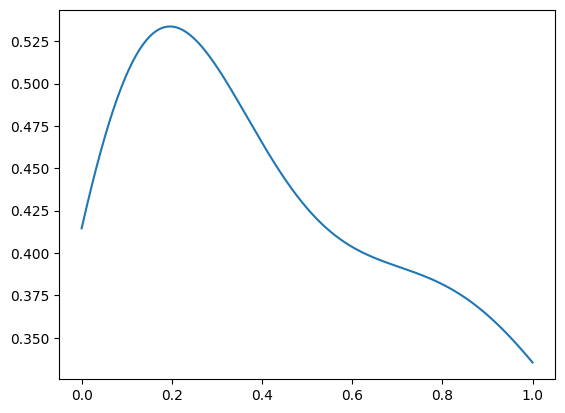

In [172]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(resultdf['error'].to_numpy().reshape(-1, 1))
# plot the kde
x = np.linspace(0, 1, 1000)
logprob = kde.score_samples(x.reshape(-1, 1))
plt.plot(x, np.exp(logprob))

In [318]:
groups = df.groupby(['NC_K', 'SIGMA_K', 'TAU'])
# get the number of unique groups
# using the groups split of the dataframe so that unique combos of NC_K, SIGMA_K, and TAU are in each group
split = 0.8
# get the unique groups
groups = df.groupby(['NC_K', 'SIGMA_K', 'TAU'])
# get the indicies of the groups
indicies = [np.array(i) for i in groups.indices.values()]
# get the number of groups
num_groups = len(indicies)
# get the number of groups to use for training
num_train_groups = int(num_groups*split)
# get the indicies of the groups to use for training
train_indicies = np.random.choice(indicies, size=num_train_groups, replace=False)
train_indicies = np.concatenate(train_indicies.flatten())
# get the indicies of the groups to use for testing
test_indicies = np.array([i for i in np.concatenate(indicies) if i not in train_indicies])
train_df = df.iloc[train_indicies]
test_df = df.iloc[test_indicies]


C:\Users\efons\AppData\Local\Temp\ipykernel_6652\584300510.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_indicies = np.random.choice(indicies, size=num_train_groups, replace=False)


In [320]:
test_df

,Unnamed: 0,Solvent,FileHandle,NC_K,SIGMA_K,TAU,Solvation_Energy,Total_Energy,No.,SoluteName,...,sigma_solvent_41,sigma_solvent_42,sigma_solvent_43,sigma_solvent_44,sigma_solvent_45,sigma_solvent_46,sigma_solvent_47,sigma_solvent_48,sigma_solvent_49,sigma_solvent_50
1838,1838,water,0044met,0.000400,0.100000,0.000525,-0.080986,-30.286090,2133,methanol,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2738,2738,water,0076but,0.000400,0.100000,0.000525,-0.005511,-72.519841,2163,2-butanone,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3507,3507,water,0036tol,0.000400,0.100000,0.000525,0.095954,-92.563420,2126,toluene,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4651,4651,water,0062dio,0.000400,0.100000,0.000525,0.041709,-78.154816,2150,"1,4-dioxane",...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5029,5029,water,0086eth,0.000400,0.100000,0.000525,-0.073923,-46.819352,2173,aceticacid,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4882,4882,water,0086eth,0.005504,0.722813,0.003820,-0.427441,-47.172820,2173,aceticacid,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5229,5229,water,0217wat,0.005504,0.722813,0.003820,-0.515908,-14.743518,2285,water,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2198,2198,water,0018cyc,0.006639,0.744844,0.003820,0.254249,-98.858564,2108,cyclohexane,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3892,3892,water,0053phe,0.006639,0.744844,0.003820,-0.443936,-83.129036,2142,phenol,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [317]:
test_indicies

array([array([1838, 2738, 3507, 4651, 5029], dtype=int64),
       array([ 800, 1292, 1783, 2685, 2930, 3459, 4089, 4596, 4979], dtype=int64),
       array([ 875, 1371, 1864, 2764, 3006, 3523, 4165, 4677, 5055], dtype=int64),
       array([1308, 1800, 2702, 3474, 4106, 4613, 4995], dtype=int64),
       array([ 846, 1341, 1833, 2733, 2976, 3503, 4135, 4646, 5024], dtype=int64),
       array([1348, 1841, 2741, 2983, 3509, 4142, 4654, 5032], dtype=int64),
       array([ 708, 1040, 1476, 2173, 2481, 3259, 3869, 4394, 4763, 5215],
             dtype=int64)                                                 ,
       array([ 692, 1023, 1459, 2156, 2465, 3242, 3852, 4377, 4746, 5198],
             dtype=int64)                                                 ,
       array([ 816, 1799, 2701, 2946, 3473, 4105, 4612, 4994], dtype=int64),
       array([ 28,  89, 152, 211, 270, 333, 395, 455], dtype=int64),
       array([  7,  68, 131, 193, 249, 312, 374, 434], dtype=int64),
       array([ 845,  951,  

In [40]:
model2 = decomposed_model(n_inputs1=53, n_inputs2=X_train.shape[1]-53)
model2 = model2.to('cuda')
model2

decomposed_model(
  (model1): NN(
    (fc1): Linear(in_features=53, out_features=10, bias=True)
    (fcs): ModuleList(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): Linear(in_features=10, out_features=10, bias=True)
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): Linear(in_features=10, out_features=10, bias=True)
      (4): Linear(in_features=10, out_features=10, bias=True)
    )
    (fout): Linear(in_features=10, out_features=3, bias=True)
  )
  (model2): NN(
    (fc1): Linear(in_features=7, out_features=10, bias=True)
    (fcs): ModuleList(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): Linear(in_features=10, out_features=10, bias=True)
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): Linear(in_features=10, out_features=10, bias=True)
      (4): Linear(in_features=10, out_features=10, bias=True)
    )
    (fout): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [41]:
model2(X_train)

torch.Size([5395, 53]) torch.Size([5395, 4])


tensor([[-0.1291],
        [-0.1291],
        [-0.1291],
        ...,
        [-0.1291],
        [-0.1291],
        [-0.1291]], device='cuda:0', grad_fn=<AddmmBackward0>)